In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

In [39]:
x_train, y_train, x_valid, y_valid = get_data()

In [40]:
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [41]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [42]:
x_train.mean(), x_train.std()

(tensor(0.0001), tensor(1.))

In [43]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [44]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [45]:
def flatten(x): return x.view(x.shape[0], -1)
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [46]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(), # 14
        nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(), # 7
        nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(), # 4
        nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [47]:
model = get_cnn_model(data)

In [48]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [49]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [50]:
%time run.fit(1, learn)

train: [1.64636921875, tensor(0.4634)]
valid: [0.5076052734375, tensor(0.8439)]
CPU times: user 14.1 s, sys: 16.2 s, total: 30.4 s
Wall time: 3.8 s


## Cuda

In [51]:
device = torch.device('cuda', 0)

In [52]:
class CudaCallback(Callback):
    def __init__(self, device): self.device = device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.to(self.device), self.yb.to(self.device)

In [53]:
torch.cuda.set_device(device)

In [54]:
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [55]:
cbfs.append(CudaCallback)

In [56]:
model = get_cnn_model(data)

In [57]:
opt = optim.SGD(model.parameters(), lr=.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [58]:
%time run.fit(3, learn)

train: [2.0313234375, tensor(0.2634, device='cuda:0')]
valid: [0.87717314453125, tensor(0.6848, device='cuda:0')]
train: [0.5258857421875, tensor(0.8315, device='cuda:0')]
valid: [0.213259033203125, tensor(0.9359, device='cuda:0')]
train: [0.2125767578125, tensor(0.9358, device='cuda:0')]
valid: [1.1388921875, tensor(0.7244, device='cuda:0')]
CPU times: user 2.83 s, sys: 400 ms, total: 3.23 s
Wall time: 3.25 s


## Refactor model

In [59]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [60]:
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)
        
def view_tfm(*size):
    def _inner(x): return x.view(*((-1,) + size))
    return _inner

In [61]:
mnist_view = view_tfm(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [62]:
nfs = [8, 16, 32, 32]

In [63]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [64]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [65]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.4, cbs=cbfs)

In [66]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [67]:
run.fit(3, learn)

train: [1.9156175, tensor(0.3399, device='cuda:0')]
valid: [0.700087890625, tensor(0.7925, device='cuda:0')]
train: [0.3538893359375, tensor(0.8952, device='cuda:0')]
valid: [0.2685021484375, tensor(0.9143, device='cuda:0')]
train: [0.1793712109375, tensor(0.9461, device='cuda:0')]
valid: [0.16446063232421876, tensor(0.9486, device='cuda:0')]


## Hooks

### Manual insertion

In [68]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            if self.training:
                self.act_means[i].append(x.mean())
                self.act_stds[i].append(x.std())
        return x
    
    def __iter__(self): return iter(self.layers)

In [69]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=.9, cbs=cbfs)

In [70]:
run.fit(2, learn)

train: [1.7805340625, tensor(0.3651, device='cuda:0')]
valid: [0.477062255859375, tensor(0.8610, device='cuda:0')]
train: [0.28536470703125, tensor(0.9148, device='cuda:0')]
valid: [0.1456048828125, tensor(0.9569, device='cuda:0')]


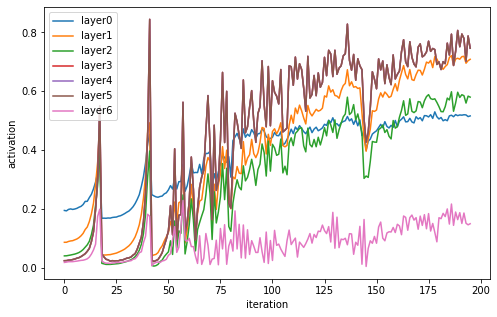

In [71]:
fig, ax = plt.subplots(figsize=(8, 5))
for l, m in enumerate(model.act_means): 
    ax.plot(m, label=f"layer{l}")
    ax.legend()
    ax.set_xlabel('iteration')
    ax.set_ylabel('activation');

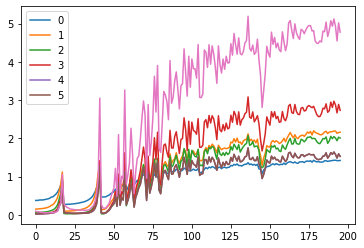

In [73]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6))

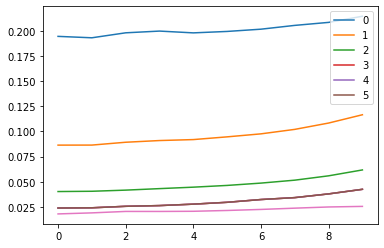

In [74]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6))

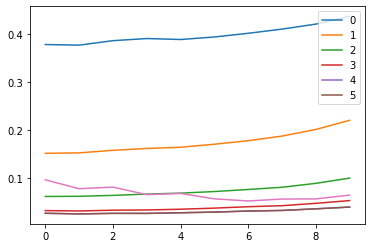

In [76]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6))

### Pytorch hooks

In [82]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.5, cbs=cbfs)

In [83]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [84]:
def append_stats(i, m, inp, outp):
    if m.training:
        act_means[i].append(outp.data.mean())
        act_stds[i].append(outp.data.std())

In [85]:
for i, l in enumerate(model):
    l.register_forward_hook(partial(append_stats, i))

In [86]:
run.fit(1, learn)

train: [2.2833325, tensor(0.1501, device='cuda:0')]
valid: [2.1105408203125, tensor(0.1395, device='cuda:0')]


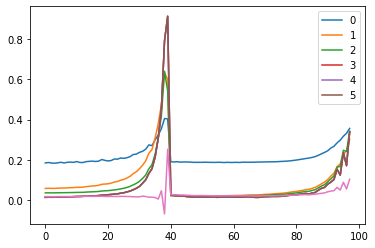

In [87]:
for o in act_means: plt.plot(o)
plt.legend(range(6))

### Hook class

In [89]:
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
        
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds.append(outp.data.std())

In [91]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [95]:
[m for m in children(model[:4])]

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 )]

In [104]:
hooks = [Hook(m, append_stats) for m in model[:4]]

In [105]:
run.fit(1, learn)

train: [1.57785015625, tensor(0.4570, device='cuda:0')]
valid: [0.482538671875, tensor(0.8495, device='cuda:0')]


In [102]:
list(model) == [m for m in model.children()]

True

# fin